In [1]:
pip install numpy pandas scikit-learn tensorflow matplotlib seaborn jupyterlab torch torch-geometric rdkit

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# === Core Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import glob

# === Progress Bar ===
from tqdm.keras import TqdmCallback

# === Scikit-learn ===
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# === TensorFlow / Keras ===
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, GlobalMaxPooling1D,
    Dense, Concatenate, BatchNormalization, Dropout
)
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import Callback, ModelCheckpoint


c:\Users\NongNam\Documents\AI_Builder\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = pd.read_csv('Kd.csv')

In [6]:
df.isna().sum()

SMILES             0
target_sequence    0
Kd                 0
dtype: int64

In [5]:
len(df)

55011

In [7]:
# 3. Encode SMILES
smiles_chars = sorted(set(''.join(df['SMILES'])))
char_to_int_smiles = {c: i + 1 for i, c in enumerate(smiles_chars)}

def encode_smiles(smiles):
    return [char_to_int_smiles[c] for c in smiles]

df['smiles_encoded'] = df['SMILES'].apply(encode_smiles)

# 4. Encode protein sequences
aa_list = 'ACDEFGHIKLMNPQRSTVWY'
aa_to_int = {aa: i + 1 for i, aa in enumerate(aa_list)}

def encode_protein(seq):
    return [aa_to_int.get(aa, 0) for aa in seq]

df['protein_encoded'] = df['target_sequence'].apply(encode_protein)

In [9]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import numpy as np

In [13]:
# --- Molecular descriptors from SMILES ---
def compute_molecular_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [None] * 5
    return [
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol)
    ]

df[['MolWt', 'LogP', 'RotatableBonds', 'HDonors', 'HAcceptors']] = df['SMILES'].apply(
    compute_molecular_descriptors
).apply(pd.Series)

# --- Protein descriptors from sequence ---
def compute_protein_descriptors(seq):
    try:
        analyzed_seq = ProteinAnalysis(seq)
        return [
            analyzed_seq.molecular_weight(),
            analyzed_seq.aromaticity(),
            analyzed_seq.instability_index(),
            analyzed_seq.gravy()
        ]
    except:
        return [None] * 4
    
df[['Prot_MW', 'Aromaticity', 'Instability', 'Hydropathy']] = df['target_sequence'].apply(
    compute_protein_descriptors
).apply(pd.Series)

[19:51:55] Explicit valence for atom # 22 N, 4, is greater than permitted
[19:51:58] Explicit valence for atom # 22 N, 4, is greater than permitted
[19:52:02] Explicit valence for atom # 22 N, 4, is greater than permitted
[19:52:11] Explicit valence for atom # 22 N, 4, is greater than permitted
[19:52:27] Explicit valence for atom # 22 N, 4, is greater than permitted
[19:52:39] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 25
[19:52:48] Explicit valence for atom # 22 N, 4, is greater than permitted


In [14]:
df = df.dropna(subset=[
    'MolWt', 'LogP', 'RotatableBonds', 'HDonors', 'HAcceptors',
    'Prot_MW', 'Aromaticity', 'Instability', 'Hydropathy'
])


In [33]:
x_descriptor = df[['MolWt', 'LogP', 'RotatableBonds', 'HDonors', 'HAcceptors']].values
X_protein_descriptor = df[['Prot_MW', 'Aromaticity', 'Instability', 'Hydropathy']].values


In [21]:
# 5. Pad sequences
max_len_smiles = 100
max_len_protein = 1000

X_smiles = pad_sequences(df['smiles_encoded'], maxlen=max_len_smiles, padding='post')
X_protein = pad_sequences(df['protein_encoded'], maxlen=max_len_protein, padding='post')
y = df['Kd'].values

In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, GlobalMaxPooling1D,
    Dense, Dropout, BatchNormalization, Concatenate
)
from tensorflow.keras.losses import MeanSquaredError

# --- Inputs ---
# 1. SMILES token branch
smiles_input = Input(shape=(max_len_smiles,), name='smiles_input')
x1 = Embedding(input_dim=len(char_to_int_smiles) + 1, output_dim=64)(smiles_input)
x1 = Conv1D(128, kernel_size=5, activation='relu', padding='same')(x1)
x1 = BatchNormalization()(x1)
x1 = Conv1D(128, kernel_size=5, activation='relu', padding='same')(x1)
x1 = GlobalMaxPooling1D()(x1)
x1 = Dropout(0.3)(x1)

# 2. Protein token branch
protein_input = Input(shape=(max_len_protein,), name='protein_input')
x2 = Embedding(input_dim=len(aa_to_int) + 1, output_dim=64)(protein_input)
x2 = Conv1D(128, kernel_size=9, activation='relu', padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Conv1D(128, kernel_size=9, activation='relu', padding='same')(x2)
x2 = GlobalMaxPooling1D()(x2)
x2 = Dropout(0.3)(x2)

# 3. Molecular descriptors branch (5 features)
mol_desc_input = Input(shape=(5,), name='mol_desc_input')
x3 = Dense(32, activation='relu')(mol_desc_input)
x3 = BatchNormalization()(x3)

# 4. Protein descriptors branch (4 features)
prot_desc_input = Input(shape=(4,), name='prot_desc_input')
x4 = Dense(32, activation='relu')(prot_desc_input)
x4 = BatchNormalization()(x4)

# --- Merge all branches ---
merged = Concatenate()([x1, x2, x3, x4])

# --- Fully connected layers ---
x = Dense(256, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# --- Output ---
output = Dense(1, activation='linear', name='kd_output')(x)

# --- Model ---
model = Model(inputs=[smiles_input, protein_input, mol_desc_input, prot_desc_input], outputs=output)
model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=['mae'])

# --- Summary ---
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ smiles_input        │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ protein_input       │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 100, 64)   │      2,688 │ smiles_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 1000, 64)  │      1,344 │ protein_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 100, 128)  │     41,088 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 1000, 128) │     73,856 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 128) │        512 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 100, 128)  │     82,048 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 1000, 128) │    147,584 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mol_desc_input      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prot_desc_input     │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_9[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_11[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │        192 │ mol_desc_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │        160 │ prot_desc_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128)       │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 466,465 (1.78 MB)

 Trainable params: 465,313 (1.78 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [23]:
len(df)

54980

In [24]:
class EpochHistorySaver(Callback):
    def __init__(self, save_dir='SE+CN_MODEL'):
        super().__init__()
        self.save_dir = save_dir
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for key, value in logs.items():
            self.history.setdefault(key, []).append(value)

        # Save history after each epoch
        filename = f'{self.save_dir}/history_epoch_{epoch+1:02d}.pkl'
        with open(filename, 'wb') as f:
            pickle.dump(self.history, f)


In [ ]:
checkpoint_cb = ModelCheckpoint(
    filepath='SE+CN_MODEL/model_epoch_{epoch:02d}.h5',
    save_freq='epoch',
    save_best_only=False,
    save_weights_only=False,
    verbose=1
)

history_cb = EpochHistorySaver(save_dir='SE+CN_MODEL')


In [ ]:
# from tensorflow.keras.models import load_model
# model = load_model('CNN_MODEL/model_epoch_59.h5', compile=False)

In [13]:
# model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=['mae'])

In [36]:
# 8. Train with progress bar
history = model.fit(
    [X_smiles, X_protein, x_descriptor, X_protein_descriptor],
    y,
    validation_split=0.22,
    epochs=100,
    batch_size=64,
    callbacks=[checkpoint_cb, history_cb]
)

Epoch 1/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - loss: 7.7446 - mae: 2.0826
Epoch 1: saving model to SE+CN_MODELl/model_epoch_01.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 422s 621ms/step - loss: 7.7342 - mae: 2.0810 - val_loss: 7.6846 - val_mae: 2.3893
Epoch 2/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - loss: 2.4542 - mae: 1.2020
Epoch 2: saving model to SE+CN_MODELl/model_epoch_02.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 394s 587ms/step - loss: 2.4537 - mae: 1.2018 - val_loss: 3.2784 - val_mae: 1.4422
Epoch 3/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - loss: 1.9882 - mae: 1.0759
Epoch 3: saving model to SE+CN_MODELl/model_epoch_03.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 361s 538ms/step - loss: 1.9882 - mae: 1.0759 - val_loss: 2.2338 - val_mae: 1.1618
Epoch 4/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 1.8227 - mae: 1.0188
Epoch 4: saving model to SE+CN_MODELl/model_epoch_04.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 343s 511ms/step - loss: 1.8225 - mae: 1.0188 - val_loss: 1.7219 - val_mae: 0.9448
Epoch 5/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - loss: 1.6557 - mae: 0.9729
Epoch 5: saving model to SE+CN_MODELl/model_epoch_05.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 341s 509ms/step - loss: 1.6557 - mae: 0.9729 - val_loss: 2.5604 - val_mae: 1.2715
Epoch 6/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - loss: 1.5749 - mae: 0.9462
Epoch 6: saving model to SE+CN_MODELl/model_epoch_06.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 342s 510ms/step - loss: 1.5749 - mae: 0.9462 - val_loss: 1.2127 - val_mae: 0.7856
Epoch 7/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - loss: 1.5085 - mae: 0.9212
Epoch 7: saving model to SE+CN_MODELl/model_epoch_07.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 344s 512ms/step - loss: 1.5085 - mae: 0.9212 - val_loss: 1.1733 - val_mae: 0.7665
Epoch 8/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - loss: 1.4478 - mae: 0.8996
Epoch 8: saving model to SE+CN_MODELl/model_epoch_08.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 339s 506ms/step - loss: 1.4477 - mae: 0.8996 - val_loss: 1.2279 - val_mae: 0.7689
Epoch 9/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - loss: 1.3581 - mae: 0.8677
Epoch 9: saving model to SE+CN_MODELl/model_epoch_09.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 339s 506ms/step - loss: 1.3581 - mae: 0.8677 - val_loss: 1.1182 - val_mae: 0.7919
Epoch 10/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - loss: 1.3295 - mae: 0.8578
Epoch 10: saving model to SE+CN_MODELl/model_epoch_10.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 340s 507ms/step - loss: 1.3295 - mae: 0.8578 - val_loss: 1.2095 - val_mae: 0.8218
Epoch 11/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - loss: 1.2880 - mae: 0.8413
Epoch 11: saving model to SE+CN_MODELl/model_epoch_11.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 342s 509ms/step - loss: 1.2880 - mae: 0.8413 - val_loss: 1.0373 - val_mae: 0.7033
Epoch 12/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 1.2267 - mae: 0.8176
Epoch 12: saving model to SE+CN_MODELl/model_epoch_12.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 343s 511ms/step - loss: 1.2267 - mae: 0.8176 - val_loss: 1.0036 - val_mae: 0.7047
Epoch 13/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - loss: 1.1806 - mae: 0.7992
Epoch 13: saving model to SE+CN_MODELl/model_epoch_13.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 341s 509ms/step - loss: 1.1806 - mae: 0.7992 - val_loss: 1.0995 - val_mae: 0.7687
Epoch 14/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - loss: 1.1801 - mae: 0.7953
Epoch 14: saving model to SE+CN_MODELl/model_epoch_14.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 341s 508ms/step - loss: 1.1800 - mae: 0.7953 - val_loss: 1.0526 - val_mae: 0.7421
Epoch 15/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - loss: 1.0951 - mae: 0.7682
Epoch 15: saving model to SE+CN_MODELl/model_epoch_15.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 342s 510ms/step - loss: 1.0951 - mae: 0.7682 - val_loss: 0.9953 - val_mae: 0.6829
Epoch 16/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - loss: 1.1069 - mae: 0.7668
Epoch 16: saving model to SE+CN_MODELl/model_epoch_16.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 342s 510ms/step - loss: 1.1069 - mae: 0.7668 - val_loss: 0.9986 - val_mae: 0.7108
Epoch 17/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 1.0260 - mae: 0.7427
Epoch 17: saving model to SE+CN_MODELl/model_epoch_17.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 343s 510ms/step - loss: 1.0261 - mae: 0.7427 - val_loss: 0.9288 - val_mae: 0.6572
Epoch 18/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 1.0022 - mae: 0.7293
Epoch 18: saving model to SE+CN_MODELl/model_epoch_18.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 343s 511ms/step - loss: 1.0022 - mae: 0.7294 - val_loss: 0.9846 - val_mae: 0.7100
Epoch 19/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 0.9935 - mae: 0.7220
Epoch 19: saving model to SE+CN_MODELl/model_epoch_19.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 343s 511ms/step - loss: 0.9935 - mae: 0.7220 - val_loss: 1.0837 - val_mae: 0.7059
Epoch 20/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 0.9596 - mae: 0.7111
Epoch 20: saving model to SE+CN_MODELl/model_epoch_20.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 343s 511ms/step - loss: 0.9597 - mae: 0.7111 - val_loss: 0.9029 - val_mae: 0.6342
Epoch 21/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - loss: 0.9378 - mae: 0.7023
Epoch 21: saving model to SE+CN_MODELl/model_epoch_21.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 343s 511ms/step - loss: 0.9378 - mae: 0.7023 - val_loss: 0.9209 - val_mae: 0.6821
Epoch 22/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - loss: 0.9105 - mae: 0.6904
Epoch 22: saving model to SE+CN_MODELl/model_epoch_22.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 344s 512ms/step - loss: 0.9105 - mae: 0.6904 - val_loss: 0.8896 - val_mae: 0.6455
Epoch 23/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 0.8911 - mae: 0.6846
Epoch 23: saving model to SE+CN_MODELl/model_epoch_23.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 342s 510ms/step - loss: 0.8911 - mae: 0.6846 - val_loss: 0.9472 - val_mae: 0.6481
Epoch 24/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - loss: 0.8626 - mae: 0.6705
Epoch 24: saving model to SE+CN_MODELl/model_epoch_24.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 379s 564ms/step - loss: 0.8626 - mae: 0.6705 - val_loss: 0.8614 - val_mae: 0.6114
Epoch 25/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - loss: 0.8250 - mae: 0.6561
Epoch 25: saving model to SE+CN_MODELl/model_epoch_25.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 377s 561ms/step - loss: 0.8252 - mae: 0.6561 - val_loss: 0.8899 - val_mae: 0.6286
Epoch 26/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - loss: 0.8337 - mae: 0.6600
Epoch 26: saving model to SE+CN_MODELl/model_epoch_26.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 375s 559ms/step - loss: 0.8337 - mae: 0.6600 - val_loss: 0.8668 - val_mae: 0.6126
Epoch 27/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - loss: 0.8006 - mae: 0.6432
Epoch 27: saving model to SE+CN_MODELl/model_epoch_27.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 375s 559ms/step - loss: 0.8006 - mae: 0.6432 - val_loss: 0.8346 - val_mae: 0.6119
Epoch 28/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - loss: 0.8117 - mae: 0.6494
Epoch 28: saving model to SE+CN_MODELl/model_epoch_28.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 374s 557ms/step - loss: 0.8117 - mae: 0.6494 - val_loss: 0.8225 - val_mae: 0.6004
Epoch 29/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - loss: 0.7904 - mae: 0.6391
Epoch 29: saving model to SE+CN_MODELl/model_epoch_29.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 383s 571ms/step - loss: 0.7904 - mae: 0.6391 - val_loss: 0.9028 - val_mae: 0.6233
Epoch 30/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - loss: 0.7730 - mae: 0.6323
Epoch 30: saving model to SE+CN_MODELl/model_epoch_30.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 385s 573ms/step - loss: 0.7730 - mae: 0.6323 - val_loss: 0.8113 - val_mae: 0.6082
Epoch 31/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 0.7665 - mae: 0.6292
Epoch 31: saving model to SE+CN_MODELl/model_epoch_31.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 555ms/step - loss: 0.7665 - mae: 0.6292 - val_loss: 0.8296 - val_mae: 0.6190
Epoch 32/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 0.7703 - mae: 0.6326
Epoch 32: saving model to SE+CN_MODELl/model_epoch_32.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 373s 556ms/step - loss: 0.7703 - mae: 0.6326 - val_loss: 0.8088 - val_mae: 0.5951
Epoch 33/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 0.7631 - mae: 0.6262
Epoch 33: saving model to SE+CN_MODELl/model_epoch_33.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 555ms/step - loss: 0.7631 - mae: 0.6262 - val_loss: 0.7949 - val_mae: 0.5846
Epoch 34/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 0.7609 - mae: 0.6267
Epoch 34: saving model to SE+CN_MODELl/model_epoch_34.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 554ms/step - loss: 0.7609 - mae: 0.6267 - val_loss: 0.7793 - val_mae: 0.5849
Epoch 35/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 0.7056 - mae: 0.6011
Epoch 35: saving model to SE+CN_MODELl/model_epoch_35.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 555ms/step - loss: 0.7057 - mae: 0.6011 - val_loss: 0.9322 - val_mae: 0.5890
Epoch 36/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - loss: 0.7033 - mae: 0.5990
Epoch 36: saving model to SE+CN_MODELl/model_epoch_36.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 554ms/step - loss: 0.7034 - mae: 0.5990 - val_loss: 0.9489 - val_mae: 0.6023
Epoch 37/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 0.6860 - mae: 0.5964
Epoch 37: saving model to SE+CN_MODELl/model_epoch_37.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 373s 555ms/step - loss: 0.6860 - mae: 0.5964 - val_loss: 0.8116 - val_mae: 0.5899
Epoch 38/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 0.6871 - mae: 0.5951
Epoch 38: saving model to SE+CN_MODELl/model_epoch_38.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 554ms/step - loss: 0.6872 - mae: 0.5951 - val_loss: 0.7654 - val_mae: 0.5791
Epoch 39/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - loss: 0.6687 - mae: 0.5844
Epoch 39: saving model to SE+CN_MODELl/model_epoch_39.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 373s 556ms/step - loss: 0.6688 - mae: 0.5845 - val_loss: 0.7820 - val_mae: 0.5868
Epoch 40/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 0.6677 - mae: 0.5834
Epoch 40: saving model to SE+CN_MODELl/model_epoch_40.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 373s 555ms/step - loss: 0.6678 - mae: 0.5834 - val_loss: 0.7782 - val_mae: 0.5827
Epoch 41/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 0.6607 - mae: 0.5797
Epoch 41: saving model to SE+CN_MODELl/model_epoch_41.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 373s 556ms/step - loss: 0.6607 - mae: 0.5797 - val_loss: 0.7653 - val_mae: 0.5946
Epoch 42/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - loss: 0.6593 - mae: 0.5803
Epoch 42: saving model to SE+CN_MODELl/model_epoch_42.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 373s 556ms/step - loss: 0.6593 - mae: 0.5803 - val_loss: 0.7704 - val_mae: 0.5723
Epoch 43/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 0.6832 - mae: 0.5935
Epoch 43: saving model to SE+CN_MODELl/model_epoch_43.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 554ms/step - loss: 0.6832 - mae: 0.5935 - val_loss: 0.7630 - val_mae: 0.5853
Epoch 44/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 0.6429 - mae: 0.5704
Epoch 44: saving model to SE+CN_MODELl/model_epoch_44.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 554ms/step - loss: 0.6429 - mae: 0.5704 - val_loss: 0.7529 - val_mae: 0.5748
Epoch 45/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 0.6528 - mae: 0.5745
Epoch 45: saving model to SE+CN_MODELl/model_epoch_45.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 555ms/step - loss: 0.6528 - mae: 0.5745 - val_loss: 0.7812 - val_mae: 0.5786
Epoch 46/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 0.6301 - mae: 0.5655
Epoch 46: saving model to SE+CN_MODELl/model_epoch_46.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 555ms/step - loss: 0.6301 - mae: 0.5655 - val_loss: 0.7588 - val_mae: 0.5647
Epoch 47/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - loss: 0.6342 - mae: 0.5705
Epoch 47: saving model to SE+CN_MODELl/model_epoch_47.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 554ms/step - loss: 0.6342 - mae: 0.5705 - val_loss: 0.7491 - val_mae: 0.5613
Epoch 48/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - loss: 0.6517 - mae: 0.5720
Epoch 48: saving model to SE+CN_MODELl/model_epoch_48.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 554ms/step - loss: 0.6517 - mae: 0.5720 - val_loss: 0.7488 - val_mae: 0.5639
Epoch 49/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - loss: 0.6170 - mae: 0.5586
Epoch 49: saving model to SE+CN_MODELl/model_epoch_49.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 371s 553ms/step - loss: 0.6170 - mae: 0.5586 - val_loss: 0.7475 - val_mae: 0.5617
Epoch 50/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - loss: 0.6105 - mae: 0.5564
Epoch 50: saving model to SE+CN_MODELl/model_epoch_50.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 374s 557ms/step - loss: 0.6105 - mae: 0.5564 - val_loss: 0.7788 - val_mae: 0.5753
Epoch 51/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - loss: 0.5927 - mae: 0.5457
Epoch 51: saving model to SE+CN_MODELl/model_epoch_51.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 373s 556ms/step - loss: 0.5927 - mae: 0.5457 - val_loss: 0.7430 - val_mae: 0.5573
Epoch 52/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 0.5943 - mae: 0.5456
Epoch 52: saving model to SE+CN_MODELl/model_epoch_52.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 554ms/step - loss: 0.5943 - mae: 0.5457 - val_loss: 0.7336 - val_mae: 0.5491
Epoch 53/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 0.5789 - mae: 0.5407
Epoch 53: saving model to SE+CN_MODELl/model_epoch_53.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 373s 555ms/step - loss: 0.5790 - mae: 0.5407 - val_loss: 0.7587 - val_mae: 0.5623
Epoch 54/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 0.6015 - mae: 0.5478
Epoch 54: saving model to SE+CN_MODELl/model_epoch_54.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 554ms/step - loss: 0.6015 - mae: 0.5478 - val_loss: 0.7234 - val_mae: 0.5468
Epoch 55/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 0.5845 - mae: 0.5434
Epoch 55: saving model to SE+CN_MODELl/model_epoch_55.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 555ms/step - loss: 0.5845 - mae: 0.5434 - val_loss: 0.7365 - val_mae: 0.5547
Epoch 56/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 0.5733 - mae: 0.5348
Epoch 56: saving model to SE+CN_MODELl/model_epoch_56.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 373s 555ms/step - loss: 0.5734 - mae: 0.5348 - val_loss: 0.7612 - val_mae: 0.5655
Epoch 57/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - loss: 0.5816 - mae: 0.5408
Epoch 57: saving model to SE+CN_MODELl/model_epoch_57.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 554ms/step - loss: 0.5816 - mae: 0.5408 - val_loss: 0.7759 - val_mae: 0.5517
Epoch 58/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 0.5724 - mae: 0.5353
Epoch 58: saving model to SE+CN_MODELl/model_epoch_58.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 555ms/step - loss: 0.5724 - mae: 0.5353 - val_loss: 0.7429 - val_mae: 0.5563
Epoch 59/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 0.5703 - mae: 0.5339
Epoch 59: saving model to SE+CN_MODELl/model_epoch_59.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 554ms/step - loss: 0.5703 - mae: 0.5339 - val_loss: 0.7253 - val_mae: 0.5455
Epoch 60/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 0.5540 - mae: 0.5243
Epoch 60: saving model to SE+CN_MODELl/model_epoch_60.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 554ms/step - loss: 0.5541 - mae: 0.5243 - val_loss: 0.7216 - val_mae: 0.5426
Epoch 61/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 0.5444 - mae: 0.5163
Epoch 61: saving model to SE+CN_MODELl/model_epoch_61.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 373s 555ms/step - loss: 0.5445 - mae: 0.5163 - val_loss: 0.8024 - val_mae: 0.5976
Epoch 62/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 0.5602 - mae: 0.5252
Epoch 62: saving model to SE+CN_MODELl/model_epoch_62.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 554ms/step - loss: 0.5602 - mae: 0.5252 - val_loss: 0.7102 - val_mae: 0.5486
Epoch 63/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 0.5474 - mae: 0.5231
Epoch 63: saving model to SE+CN_MODELl/model_epoch_63.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 554ms/step - loss: 0.5475 - mae: 0.5231 - val_loss: 0.7444 - val_mae: 0.5522
Epoch 64/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 0.5692 - mae: 0.5268
Epoch 64: saving model to SE+CN_MODELl/model_epoch_64.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 554ms/step - loss: 0.5692 - mae: 0.5268 - val_loss: 0.7577 - val_mae: 0.5565
Epoch 65/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 0.5396 - mae: 0.5152
Epoch 65: saving model to SE+CN_MODELl/model_epoch_65.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 555ms/step - loss: 0.5396 - mae: 0.5152 - val_loss: 0.7268 - val_mae: 0.5434
Epoch 66/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 0.5317 - mae: 0.5071
Epoch 66: saving model to SE+CN_MODELl/model_epoch_66.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 373s 555ms/step - loss: 0.5317 - mae: 0.5071 - val_loss: 0.7432 - val_mae: 0.5455
Epoch 67/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 0.5305 - mae: 0.5103
Epoch 67: saving model to SE+CN_MODELl/model_epoch_67.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 554ms/step - loss: 0.5305 - mae: 0.5103 - val_loss: 0.7361 - val_mae: 0.5490
Epoch 68/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 0.5441 - mae: 0.5139
Epoch 68: saving model to SE+CN_MODELl/model_epoch_68.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 554ms/step - loss: 0.5441 - mae: 0.5139 - val_loss: 0.7606 - val_mae: 0.5744
Epoch 69/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 0.5312 - mae: 0.5109
Epoch 69: saving model to SE+CN_MODELl/model_epoch_69.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 373s 555ms/step - loss: 0.5312 - mae: 0.5109 - val_loss: 0.7452 - val_mae: 0.5406
Epoch 70/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 0.5457 - mae: 0.5185
Epoch 70: saving model to SE+CN_MODELl/model_epoch_70.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 373s 556ms/step - loss: 0.5457 - mae: 0.5185 - val_loss: 0.7671 - val_mae: 0.5587
Epoch 71/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 0.5236 - mae: 0.5053
Epoch 71: saving model to SE+CN_MODELl/model_epoch_71.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 555ms/step - loss: 0.5236 - mae: 0.5053 - val_loss: 0.7240 - val_mae: 0.5383
Epoch 72/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - loss: 0.5125 - mae: 0.4988
Epoch 72: saving model to SE+CN_MODELl/model_epoch_72.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 375s 559ms/step - loss: 0.5125 - mae: 0.4988 - val_loss: 0.7306 - val_mae: 0.5495
Epoch 73/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - loss: 0.5020 - mae: 0.4936
Epoch 73: saving model to SE+CN_MODELl/model_epoch_73.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 554ms/step - loss: 0.5020 - mae: 0.4936 - val_loss: 0.7165 - val_mae: 0.5374
Epoch 74/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - loss: 0.5081 - mae: 0.4970
Epoch 74: saving model to SE+CN_MODELl/model_epoch_74.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 371s 553ms/step - loss: 0.5082 - mae: 0.4970 - val_loss: 0.7019 - val_mae: 0.5383
Epoch 75/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - loss: 0.5175 - mae: 0.4984
Epoch 75: saving model to SE+CN_MODELl/model_epoch_75.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 373s 556ms/step - loss: 0.5175 - mae: 0.4984 - val_loss: 0.7229 - val_mae: 0.5502
Epoch 76/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 0.5044 - mae: 0.4916
Epoch 76: saving model to SE+CN_MODELl/model_epoch_76.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 555ms/step - loss: 0.5044 - mae: 0.4916 - val_loss: 0.7369 - val_mae: 0.5414
Epoch 77/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 0.5026 - mae: 0.4905
Epoch 77: saving model to SE+CN_MODELl/model_epoch_77.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 555ms/step - loss: 0.5027 - mae: 0.4906 - val_loss: 0.7048 - val_mae: 0.5383
Epoch 78/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 0.5031 - mae: 0.4940
Epoch 78: saving model to SE+CN_MODELl/model_epoch_78.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 373s 555ms/step - loss: 0.5031 - mae: 0.4940 - val_loss: 0.7272 - val_mae: 0.5407
Epoch 79/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 0.5112 - mae: 0.4938
Epoch 79: saving model to SE+CN_MODELl/model_epoch_79.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 373s 556ms/step - loss: 0.5112 - mae: 0.4938 - val_loss: 0.7105 - val_mae: 0.5324
Epoch 80/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 0.5135 - mae: 0.4973
Epoch 80: saving model to SE+CN_MODELl/model_epoch_80.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 373s 556ms/step - loss: 0.5135 - mae: 0.4972 - val_loss: 0.7228 - val_mae: 0.5391
Epoch 81/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 0.5038 - mae: 0.4880
Epoch 81: saving model to SE+CN_MODELl/model_epoch_81.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 554ms/step - loss: 0.5038 - mae: 0.4880 - val_loss: 0.7379 - val_mae: 0.5475
Epoch 82/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 0.4852 - mae: 0.4798
Epoch 82: saving model to SE+CN_MODELl/model_epoch_82.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 554ms/step - loss: 0.4852 - mae: 0.4798 - val_loss: 0.7024 - val_mae: 0.5328
Epoch 83/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 0.4832 - mae: 0.4807
Epoch 83: saving model to SE+CN_MODELl/model_epoch_83.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 555ms/step - loss: 0.4832 - mae: 0.4807 - val_loss: 0.7105 - val_mae: 0.5345
Epoch 84/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 0.4926 - mae: 0.4832
Epoch 84: saving model to SE+CN_MODELl/model_epoch_84.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 554ms/step - loss: 0.4926 - mae: 0.4833 - val_loss: 0.7653 - val_mae: 0.5517
Epoch 85/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 0.5046 - mae: 0.4896
Epoch 85: saving model to SE+CN_MODELl/model_epoch_85.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 554ms/step - loss: 0.5045 - mae: 0.4896 - val_loss: 0.7099 - val_mae: 0.5321
Epoch 86/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 0.4769 - mae: 0.4737
Epoch 86: saving model to SE+CN_MODELl/model_epoch_86.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 555ms/step - loss: 0.4770 - mae: 0.4738 - val_loss: 0.7030 - val_mae: 0.5307
Epoch 87/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 0.4932 - mae: 0.4829
Epoch 87: saving model to SE+CN_MODELl/model_epoch_87.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 555ms/step - loss: 0.4932 - mae: 0.4829 - val_loss: 0.7014 - val_mae: 0.5328
Epoch 88/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 0.4734 - mae: 0.4749
Epoch 88: saving model to SE+CN_MODELl/model_epoch_88.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 373s 555ms/step - loss: 0.4734 - mae: 0.4749 - val_loss: 0.7099 - val_mae: 0.5309
Epoch 89/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 0.4720 - mae: 0.4759
Epoch 89: saving model to SE+CN_MODELl/model_epoch_89.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 373s 555ms/step - loss: 0.4720 - mae: 0.4759 - val_loss: 0.7020 - val_mae: 0.5267
Epoch 90/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - loss: 0.4633 - mae: 0.4716
Epoch 90: saving model to SE+CN_MODELl/model_epoch_90.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 374s 557ms/step - loss: 0.4634 - mae: 0.4716 - val_loss: 0.6980 - val_mae: 0.5279
Epoch 91/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - loss: 0.4828 - mae: 0.4845
Epoch 91: saving model to SE+CN_MODELl/model_epoch_91.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 373s 557ms/step - loss: 0.4828 - mae: 0.4845 - val_loss: 0.7102 - val_mae: 0.5409
Epoch 92/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - loss: 0.4874 - mae: 0.4845
Epoch 92: saving model to SE+CN_MODELl/model_epoch_92.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 374s 557ms/step - loss: 0.4873 - mae: 0.4845 - val_loss: 0.6910 - val_mae: 0.5315
Epoch 93/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - loss: 0.4701 - mae: 0.4726
Epoch 93: saving model to SE+CN_MODELl/model_epoch_93.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 373s 557ms/step - loss: 0.4701 - mae: 0.4726 - val_loss: 0.7175 - val_mae: 0.5456
Epoch 94/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - loss: 0.4833 - mae: 0.4817
Epoch 94: saving model to SE+CN_MODELl/model_epoch_94.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 373s 557ms/step - loss: 0.4833 - mae: 0.4817 - val_loss: 0.7070 - val_mae: 0.5357
Epoch 95/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - loss: 0.4797 - mae: 0.4795
Epoch 95: saving model to SE+CN_MODELl/model_epoch_95.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 375s 558ms/step - loss: 0.4797 - mae: 0.4795 - val_loss: 0.6987 - val_mae: 0.5263
Epoch 96/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 0.4700 - mae: 0.4735
Epoch 96: saving model to SE+CN_MODELl/model_epoch_96.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 372s 555ms/step - loss: 0.4700 - mae: 0.4735 - val_loss: 0.6940 - val_mae: 0.5331
Epoch 97/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - loss: 0.4660 - mae: 0.4765
Epoch 97: saving model to SE+CN_MODELl/model_epoch_97.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 373s 556ms/step - loss: 0.4660 - mae: 0.4765 - val_loss: 0.6941 - val_mae: 0.5329
Epoch 98/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - loss: 0.4630 - mae: 0.4699
Epoch 98: saving model to SE+CN_MODELl/model_epoch_98.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 373s 556ms/step - loss: 0.4630 - mae: 0.4699 - val_loss: 0.7351 - val_mae: 0.5402
Epoch 99/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - loss: 0.4647 - mae: 0.4695
Epoch 99: saving model to SE+CN_MODELl/model_epoch_99.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 374s 558ms/step - loss: 0.4647 - mae: 0.4695 - val_loss: 0.6983 - val_mae: 0.5330
Epoch 100/100
670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - loss: 0.4734 - mae: 0.4787
Epoch 100: saving model to SE+CN_MODELl/model_epoch_100.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 374s 558ms/step - loss: 0.4734 - mae: 0.4787 - val_loss: 0.6926 - val_mae: 0.5359


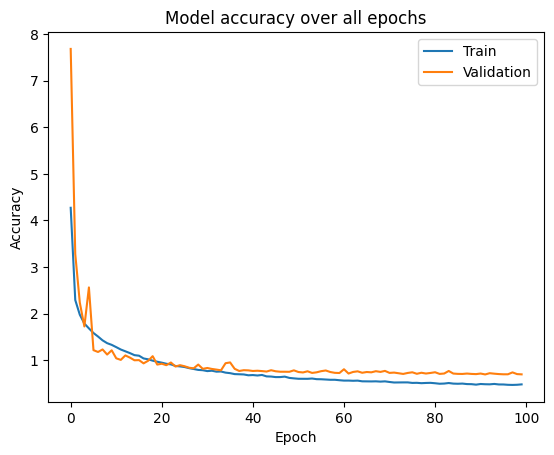

In [ ]:
# Load all history files
history_files = sorted(glob.glob('SE+CN_MODEL/history_epoch_*.pkl'))

full_history = {}
for file in history_files:
    with open(file, 'rb') as f:
        epoch_history = pickle.load(f)
    for key, values in epoch_history.items():
        full_history.setdefault(key, []).extend(values[len(full_history.get(key, [])):])

# Plot
import matplotlib.pyplot as plt

plt.plot(full_history['loss'])
plt.plot(full_history['val_loss'])
plt.title('Model accuracy over all epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()